In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-11-15-22-08-29-780194


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "BreakoutNoFrameskip-v4"
env_type = "atari"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0


In [4]:
checkpoint_min = 100
checkpoint_max = 3600
checkpoint_step = 100
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00200', '00300', '00400', '00500', '00600', '00700', '00800', '00900', '01000', '01100', '01200', '01300', '01400', '01500', '01600', '01700', '01800', '01900', '02000', '02100', '02200', '02300', '02400', '02500', '02600', '02700', '02800', '02900', '03000', '03100', '03200', '03300', '03400', '03500', '03600']


In [5]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/breakout/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 1
    done = False
    traj = []
    r = 0
    for i in range(episode_count):
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
                
    demonstrations.append(traj)
    learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 389, return: [6.]
checkpoint: 00200, steps: 421, return: [7.]
checkpoint: 00300, steps: 755, return: [23.]
checkpoint: 00400, steps: 961, return: [30.]
checkpoint: 00500, steps: 905, return: [35.]
checkpoint: 00600, steps: 1158, return: [36.]
checkpoint: 00700, steps: 1619, return: [91.]
checkpoint: 00800, steps: 1264, return: [62.]
checkpoint: 00900, steps: 850, return: [41.]
checkpoint: 01000, steps: 1130, return: [54.]
checkpoint: 01100, steps: 1388, return: [67.]
checkpoint: 01200, steps: 1841, return: [160.]
checkpoint: 01300, steps: 1218, return: [63.]
checkpoint: 01400, steps: 1372, return: [102.]
checkpoint: 01500, steps: 1495, return: [145.]
checkpoint: 01600, steps: 1528, return: [242.]
checkpoint: 01700, steps: 2203, return: [264.]
checkpoint: 01800, steps: 1895, return: [301.]
checkpoint: 01900, steps: 1413, return: [75.]
checkpoint: 02000, steps: 2156, return: [338.]
checkpoint: 02100, steps: 1763, return: [171.]
checkpoint: 02200, steps: 2228, re

Let's plot the returns to see if they are roughly monotonically increasing.

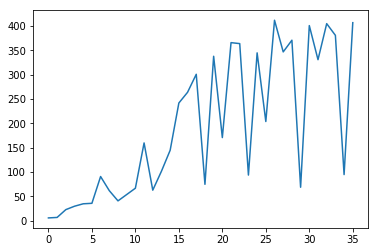

In [6]:
plt.plot(learning_returns)
plt.show()

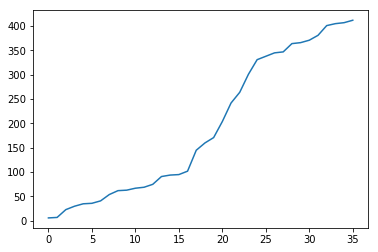

In [24]:
#cheat and sort them to see if it helps learning
sorted_demos = [d for _,d in sorted(zip(learning_returns,demonstrations))]
sorted_returns = sorted(learning_returns)
plt.plot(sorted_returns)

Split the data into train and validation sets

In [25]:
train_demos = []
train_returns = []
valid_demos = []
valid_returns = []

for i,d in enumerate(sorted_demos):
    if i % 2 == 0:
        train_demos.append(d)
        train_returns.append(sorted_returns[i])
    else:
        valid_demos.append(d)
        valid_returns.append(sorted_returns[i])

print(train_returns)
print(valid_returns)

[array([6.], dtype=float32), array([23.], dtype=float32), array([35.], dtype=float32), array([41.], dtype=float32), array([62.], dtype=float32), array([67.], dtype=float32), array([75.], dtype=float32), array([94.], dtype=float32), array([102.], dtype=float32), array([160.], dtype=float32), array([204.], dtype=float32), array([264.], dtype=float32), array([331.], dtype=float32), array([345.], dtype=float32), array([364.], dtype=float32), array([371.], dtype=float32), array([401.], dtype=float32), array([407.], dtype=float32)]
[array([7.], dtype=float32), array([30.], dtype=float32), array([36.], dtype=float32), array([54.], dtype=float32), array([63.], dtype=float32), array([69.], dtype=float32), array([91.], dtype=float32), array([95.], dtype=float32), array([145.], dtype=float32), array([171.], dtype=float32), array([242.], dtype=float32), array([301.], dtype=float32), array([338.], dtype=float32), array([347.], dtype=float32), array([366.], dtype=float32), array([381.], dtype=float3

Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        self.fc1 = nn.Linear(2592, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2) #get into NCHW format
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 2592)
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #keep rewards positive, might help for survival games
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [19]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j such that i > j
        j = np.random.randint(len(trajectories)-1) #make sure there is at least one later trajectory
        i = np.random.randint(j+1,len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        labels = np.array([[0]])
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

In [12]:
#doesn't work on my laptop, CUDA out of memory!!!
reward = Net()
reward.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward.parameters(), lr = 0.00001)
learn_reward(reward, optimizer, train_demos, 200)

RuntimeError: CUDA error: out of memory

Print out learned return for all demos. should be roughly increasing

In [100]:
with torch.no_grad():
    print(torch.cat([reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)) for traj in demonstrations]))

tensor([[ 6.3470],
        [10.4219],
        [16.0051],
        [21.5090],
        [25.9470]], device='cuda:0')


Look at predicted reward over last demo. It's all +1 since demos are monotonically increasing. Maybe need to truncate demos to fixed length?

0
1
2
3
4


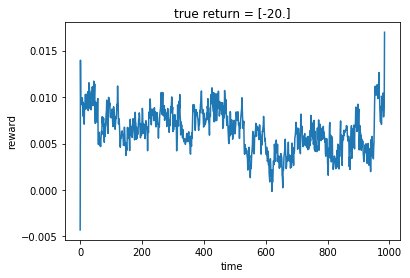

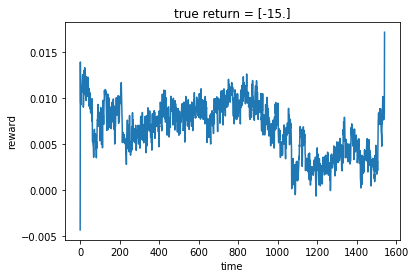

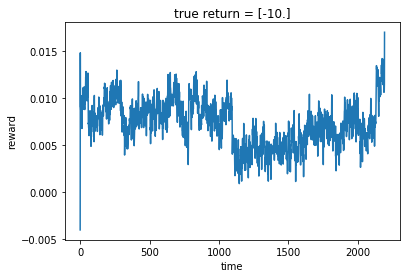

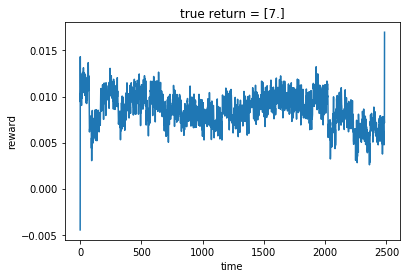

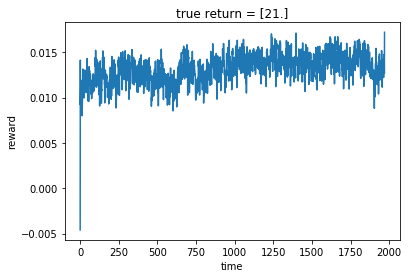

In [101]:

#for last demo

cnt = 0
with torch.no_grad():
    for d in demonstrations:
        rewards = []
        print(cnt)
        for s in d:
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(learning_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()


Trying shorter snippets of the demos, should use a sliding window over all demos to get lots of training data, but just  trying the last H frames for now, where H is length of first (the shortest) demo 

In [27]:
H = len(train_demos[0])
demos_fh = [d[len(d)-H:] for d in train_demos]
reward_fh = Net()
reward_fh.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward_fh.parameters(), lr = 0.0001)
learn_reward(reward_fh, optimizer, demos_fh, 600)

49 0.4190509033203125
99 0.12256378173828125
149 0.02617919921875
199 0.04443634033203125
249 0.02464935302734375
299 0.1550189208984375
349 0.02472137451171875
399 0.00710235595703125
449 0.00882720947265625
499 0.002322998046875
549 0.0058648681640625
599 0.02037109375
finished training


See what predicted returns look like compared to actual

In [31]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in train_demos]
for i, p in enumerate(pred_returns):
    print(i,p,train_returns[i])

0 171.126953125 [6.]
1 335.76593017578125 [23.]
2 407.18182373046875 [35.]
3 386.8476257324219 [41.]
4 578.8345336914062 [62.]
5 631.7561645507812 [67.]
6 644.45263671875 [75.]
7 619.1474609375 [94.]
8 641.7732543945312 [102.]
9 865.8160400390625 [160.]
10 986.8495483398438 [204.]
11 1067.9058837890625 [264.]
12 829.264892578125 [331.]
13 932.1914672851562 [345.]
14 944.0535278320312 [364.]
15 1071.9627685546875 [371.]
16 2853.6474609375 [401.]
17 1331.2156982421875 [407.]


389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


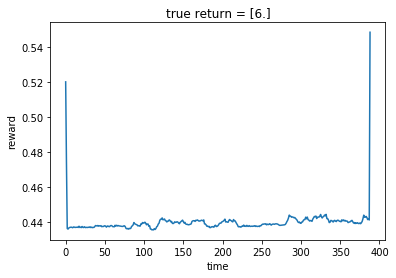

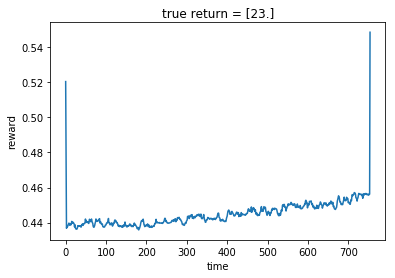

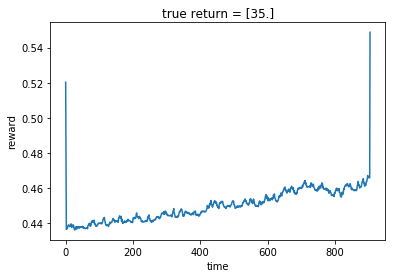

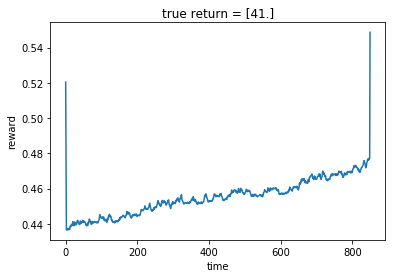

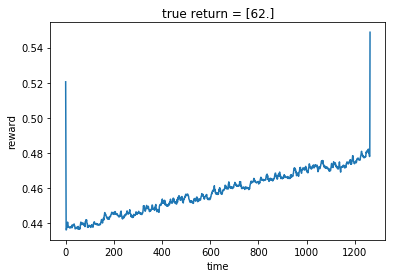

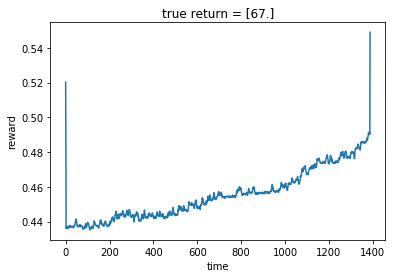

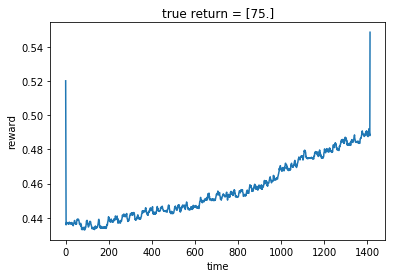

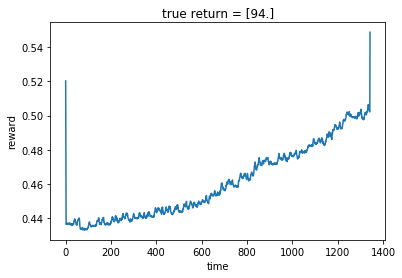

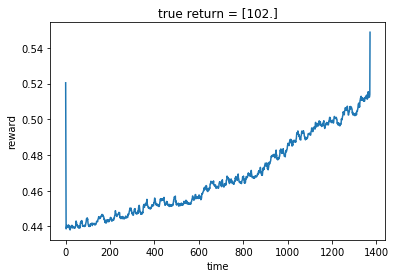

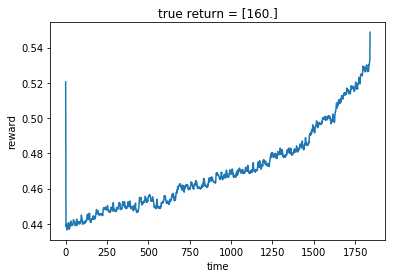

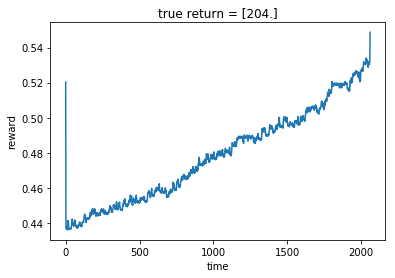

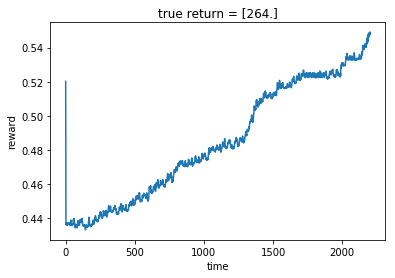

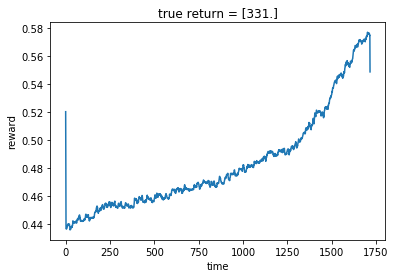

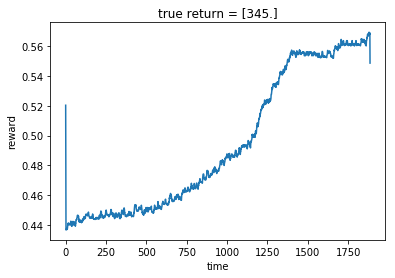

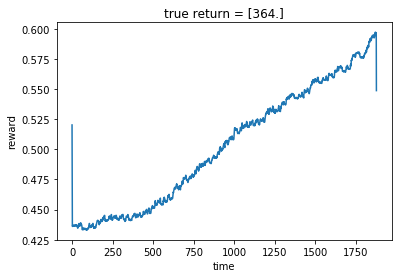

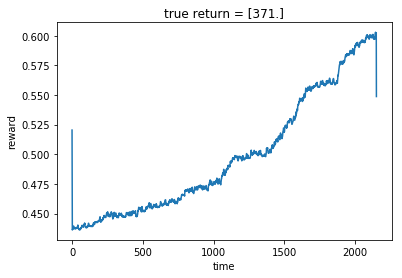

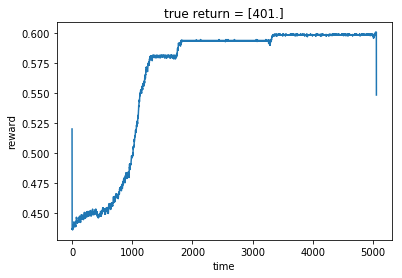

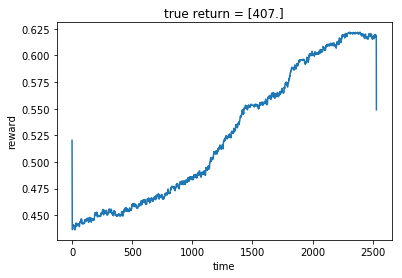

In [33]:
#print out the actual time series of rewards predicted by nnet for each trajectory.
#They are monotonically increasing, so that's good!
for d in demos_fh:
    print(len(d))

cnt = 0
with torch.no_grad():
    for d in train_demos:
        rewards = []
        print(cnt)
        for s in d:
            r = reward_fh.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(train_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()

Check validation accuracy

In [32]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 186.1346893310547 [7.]
1 430.2178039550781 [30.]
2 518.6595458984375 [36.]
3 523.4966430664062 [54.]
4 556.0657958984375 [63.]
5 630.5890502929688 [69.]
6 750.6995239257812 [91.]
7 579.3140258789062 [95.]
8 699.5828247070312 [145.]
9 821.8624877929688 [171.]
10 721.78466796875 [242.]
11 944.6196899414062 [301.]
12 1041.567138671875 [338.]
13 1224.5562744140625 [347.]
14 1099.1944580078125 [366.]
15 941.4971313476562 [381.]
16 5694.58447265625 [405.]
17 1253.0423583984375 [412.]


Okay. So now we want to optimize a policy using the learned reward to see how well it can perform if we run RL to convergence on it...